In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import os
import pandas_profiling as pp
sb.set() # set the default Seaborn style for graphics
sb.set_style("darkgrid")
sb.set_context("poster", font_scale = .5, rc={"grid.linewidth": 0.6})

# For Support Vector Machine
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler

# For accuracy analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

## Dataset Preparation

Features:

- Age | Objective Feature | age | int (days) 
- Height | Objective Feature | height | int (cm) | 
- Weight | Objective Feature | weight | float (kg) | 
- Gender | Objective Feature | gender | categorical code | 
- Systolic blood pressure | Examination Feature | ap_hi | int | 
- Diastolic blood pressure | Examination Feature | ap_lo | int | 
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal | 
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal | 
- Smoking | Subjective Feature | smoke | binary | 
- Alcohol intake | Subjective Feature | alco | binary | 
- Physical activity | Subjective Feature | active | binary | 
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary | 

## Importing the Dataset

In [3]:
cardio = pd.read_csv('cardio_train.csv', sep=';')
cardio.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


In [4]:
print("Data type : ", type(cardio))
print("Data dims : ", cardio.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (70000, 13)


In [5]:
cardio_data = cardio.copy()

## Dataset cleanup
- Duplicates can result in overfitting hence we remove duplicated samples.
- The **id** column does not provide useful information or aid in training hence we drop the column.
- In the raw dataset, age is given in days resulting in extremely large values and is hard to interpret hence we convert into years.
- **Weight** and **Height** individually is not a good indicator of health or potential presence of heart diesease, hence we combine them into a single feature, **BMI**, to allow for better intepretation. 

In [6]:
cardio_data = cardio_data.drop_duplicates()
# Drop id column as it doesnt help 
cardio_data = cardio_data.drop(columns='id')

# Convert age into years
cardio_data['age'] = cardio_data['age']//365

# Combine age & weight into BMI
cardio_data['bmi'] = cardio_data["weight"] / (cardio_data["height"]/100)**2
cardio_data = cardio_data.drop(columns=['weight', 'height'])

The dataset contains a mix of categorical features and numerical features. We convert them to their specific datatype accordingly.

In [7]:
# Convert categorical variables into “category” data type
cat_attribs = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

# Create a list that contains numerical attributes
num_attribs = ['age', 'bmi', 'ap_hi', 'ap_lo']

# Covert the data type of categorical attributes into "category"
for cat_attrib in cat_attribs:                                # iterate over each categorical attribute
  cardio_data[cat_attrib] = cardio_data[cat_attrib].astype('category')  # convert data type

cardio_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,70000.0,52.840671,6.766774,29.000000,48.000000,53.000000,58.000000,64.000000
ap_hi,70000.0,128.817286,154.011419,-150.000000,120.000000,120.000000,140.000000,16020.000000
ap_lo,70000.0,96.630414,188.472530,-70.000000,80.000000,80.000000,90.000000,11000.000000
bmi,70000.0,27.556513,6.091511,3.471784,23.875115,26.374068,30.222222,298.666667


Upon looking at the description of the numerical features, we notice that for **ap_hi**, **ap_lo**, and **BMI** there are samples which contain unrealistic values that could potentially skew the data. We will have to remove those samples.

We also know from the dataset description that **gender** is classified under 1 for female and 2 for male. We also should convert it to binary(0,1) for the machine learning algorithms. The conversion is done using the `get_dummies` method from Pandas.

Generating 2 column list containing dummy variables from the **gender** feature for **female(1)** and **male(2)**, we take the **female** column as it labels female as 0 and male as 1 and replace the **gender** column with it.

In [8]:
#Convert gender to binary From Female:1 Male:2 -> Female:0 Male:1
dummygen = pd.get_dummies(cardio_data["gender"])

#Take first column (Female:0) 
dummygen = dummygen.drop([2], axis=1)

#Concatenate and remove original column
cardio_data = pd.concat((dummygen, cardio_data), axis=1) 
cardio_data = cardio_data.drop(["gender"], axis=1)
cardio_data = cardio_data.rename(columns={1:"gender"})
cardio_data.sample(5)

,gender,age,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
24163,0,49,100,60,1,1,1,0,0,0,37.716263
41505,1,57,806,0,1,1,0,0,1,0,17.287907
21765,1,48,90,60,1,1,0,0,1,0,29.642685
1835,0,59,120,80,3,1,0,0,1,1,33.874064
65907,0,64,150,80,1,1,0,0,1,1,25.826446


We also remove the bad samples with unrealistic blood pressure values and BMI values.

In [9]:
#filter out bad bp data
filter_max = ((cardio_data["ap_hi"]>220) | (cardio_data["ap_lo"]>120))
filter_min = ((cardio_data["ap_hi"]<90) | (cardio_data["ap_lo"]<60))
cardio_data = cardio_data[~filter_max]
cardio_data = cardio_data[~filter_min]
len(cardio_data)

C:\Users\User\AppData\Local\Temp\ipykernel_7076\778566219.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cardio_data = cardio_data[~filter_min]


68452

In [10]:
# Extract feature bmi from the dataset
bmi = cardio_data['bmi']

# Drop outliers
cardio_data = cardio_data.drop(cardio_data.loc[(bmi < 10) | (bmi > 80)].index)
len(cardio_data)

68416

After filtering out the bad samples, we are left with 68416 samples out of the original 70000. We are still left with 97.7% of our dataset, losing only around 2.3%, allowing us to still have a good representation of the original dataset.

For the purpose of machine learning, we want the categorical type features to be represented efficiently. Hence, using the `get_dummies` method, we convert **cholesterol** and **gluc** to 3 columns each, and concatenate them to our dataset, removing the original. The columns would indicate the level of **cholesterol** and **glucose** binarily, and act as 'switches' that turn the parameter on and off in a machine learning algorithm, allowing us to treat it statistically like a interval-level variable.

In [11]:
# Create dummy variables for non-binary categorical data
dummies = pd.get_dummies(cardio_data[['cholesterol','gluc']])
dummies.head(10)

,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,1,0,0,1,0,0
1,0,0,1,1,0,0
2,0,0,1,1,0,0
3,1,0,0,1,0,0
4,1,0,0,1,0,0
5,0,1,0,0,1,0
6,0,0,1,1,0,0
7,0,0,1,0,0,1
8,1,0,0,1,0,0
9,1,0,0,1,0,0


We rename the different levels of **cholesterol** and **gluc**


| Old Name    | New Name    | Meaning          |
| :---        |    :----    |          :---    |
| 1           | n           | Normal           |
| 2           | an          | Above Normal     |
| 3           | wan         | Well Above Normal|

In [12]:
cardio_data = pd.concat([cardio_data,dummies],axis=1)
cardio_data.drop(['cholesterol','gluc'],axis=1,inplace=True)
cardio_data.rename(columns = {'cholesterol_1':'cholesterol_n','cholesterol_2':'cholesterol_an','cholesterol_3':'cholesterol_wan'}, inplace = True)
cardio_data.rename(columns = {'gluc_1':'gluc_n','gluc_2':'gluc_an','gluc_3':'gluc_wan'}, inplace = True)

In [13]:
cardio_data.sample(10)

,gender,age,ap_hi,ap_lo,smoke,alco,active,cardio,bmi,cholesterol_n,cholesterol_an,cholesterol_wan,gluc_n,gluc_an,gluc_wan
10809,0,47,130,85,0,0,1,0,27.343750,1,0,0,1,0,0
21070,1,59,110,70,0,0,1,1,39.256529,0,0,1,1,0,0
42288,1,59,110,80,0,0,1,0,26.078972,1,0,0,1,0,0
31802,0,50,110,70,1,1,1,0,30.863007,1,0,0,0,1,0
12892,1,52,120,80,0,0,1,0,24.005487,1,0,0,1,0,0
27580,0,39,110,80,0,0,1,0,25.689562,1,0,0,1,0,0
62954,1,52,130,90,0,0,1,1,43.282548,1,0,0,1,0,0
41210,1,49,100,70,0,0,1,0,20.820940,1,0,0,1,0,0
12112,1,50,100,80,0,0,1,0,23.634033,0,1,0,1,0,0
66052,1,56,120,80,0,0,1,1,24.919900,1,0,0,1,0,0


In [14]:
cardio_data.shape

(68416, 15)

## Feature Scaling
For the numerical datatypes in our dataset, the range of values of the features varies widely due to thier units (eg. Age in years, Bp in mmHg). This can affect algorithms that utilizes Euclidean distance, as the feature with the the largest range of values will have a more significant impact. We want to normalize or scale the data such that each feature contributes proportionately to the calculation.

There are 2 widely used methods of feature scaling. The first being Normalization, which maps the feature values to into a [0,1] interval.
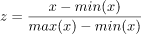
The second is Standardization which shifts the values of all features to a 0 mean, and maps them into a range where they have a standard deviation of 1.


We choose Standardization as it is the more common approach for SVM, it centres the data and makes it more flexible to new values not yet seen in the dataset.

In [15]:
to_be_scaled_feat = ['age', 'ap_hi', 'ap_lo','bmi']
scaler=StandardScaler()
scaler.fit(cardio_data[to_be_scaled_feat])
cardio_data[to_be_scaled_feat] = scaler.transform(cardio_data[to_be_scaled_feat])

In [16]:
cardio_data.sample(10)

,gender,age,ap_hi,ap_lo,smoke,alco,active,cardio,bmi,cholesterol_n,cholesterol_an,cholesterol_wan,gluc_n,gluc_an,gluc_wan
69178,1,1.650219,0.201038,-0.144666,0,0,1,0,-0.087930,1,0,0,1,0,0
50675,0,0.763634,-0.405622,-0.144666,0,0,1,0,-0.163040,1,0,0,1,0,0
5541,1,0.615870,-0.405622,-0.144666,0,1,1,0,-1.384915,1,0,0,1,0,0
53065,0,0.615870,0.989696,1.045389,0,1,1,1,-0.280584,1,0,0,1,0,0
52328,1,0.172578,0.201038,-0.144666,0,0,1,0,-1.682313,1,0,0,0,0,1
41485,1,1.354691,-0.405622,-0.144666,0,0,1,1,-0.254426,1,0,0,1,0,0
6979,1,-2.043884,-1.012282,-1.226534,0,0,0,0,-1.160247,1,0,0,1,0,0
44341,0,-2.043884,-1.012282,-0.144666,0,0,0,0,1.098587,1,0,0,1,0,0
57682,1,1.354691,-0.405622,-0.144666,0,0,1,0,-0.600896,1,0,0,1,0,0
19228,1,-0.861771,-1.618942,-0.144666,0,0,1,0,-0.765607,1,0,0,1,0,0


## Split Dataset into Training Set and Test Set
We first extract the test variable **cardio** from the dataset, we then split the remaining features into a training set and test set before doing the same for the test variable column.

In [17]:
target_name = 'cardio'
data_target = cardio_data[target_name] #Extract cardio column as target variable
data = cardio_data.drop([target_name], axis=1) #Drop cardio column from rest of data

We will do a 70-30 split. Split 30% test, remaining 70% train. **Xtrain** and **Xtest** will act as our training data, while **Ytrain** and **Ytest** will act as our test set.

In [18]:
Xtrain, Ytrain, Xtest, Ytest = train_test_split(data, data_target, test_size=0.3, random_state=0)

From the training set, we extract 30% as a validation set. In the context of SVM, we will be using the validation set to aid in determining our hyperparameter.
Extract 30% from training set as validation set. (**Zval, Zvaltest**)
Remainder (**Ztrain, Ztest**) will act as our training set

In [19]:
Ztrain, Zval, Ztest, Zvaltest = train_test_split(Xtrain, Xtest, test_size=0.3, random_state=0)

In [20]:
print(Ztrain.shape)
print(Zval.shape)

(33523, 14)
(14368, 14)


In [22]:
np.array(Zval).var()

0.47786215198139737

## Support Vector Machines
In machine learning, support vector machines, SVMs are supervised learning models with associated learning algorithms that analyze data for classification and regression analysis. Given a set of training examples, each marked as belonging to one of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier. 

In our problem, the presence of CVDs is classified as a binary categorical variable. Hence, SVM can be used as a classification model to predict the target variable based on provided features.

SVM works by projecting each sample onto a point in an N-dimensional space(N being the number of features), and determining a hyperplane which seperates and classifies the points based on the target variable. Once a hyperplane is determined, it acts as a decision boundary that can classify unknown datapoints based on its position in space relative to the hyperplane.

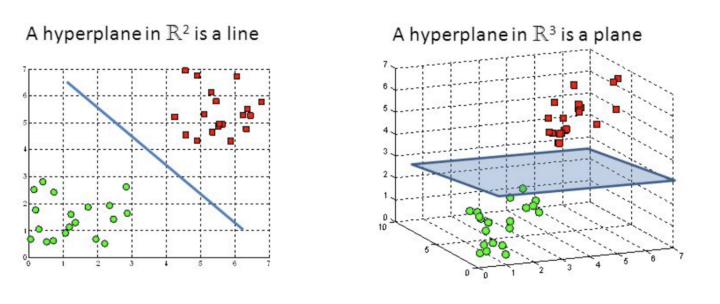

### Kernel Trick
Most datasets in the real world cannot be easily seperated by hyperplane as they are non-linear. A workaround for this is to apply a tranformation, a Kernel, to the non-linear data to project it into a higher dimensional space making it easier for a hyperplane to classify the data. This workaround is referred to as the **Kernel Trick**.
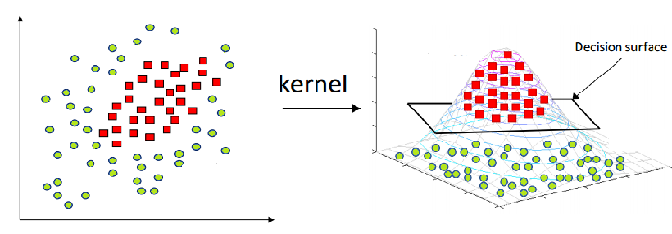

### Types of kernel
**Linear Kernel** - The Linear Kernel, also called the 'Non-kernel', is the simplest form of kernels as it does not project the data into higher dimensional space. It is typically used for datasets that can be seperated linearly and contains a large amount of features, as increasing dimensionality on these data does not necessarily increase seperability. The Linear Kernel is expressed as:


**Polynomial Kernel** - The Polynomial Kernel projects the data to a higher dimensional space, depending on its chosen parameter: **Degree(D)**. This allows for the fitting of a hyperplane on non-linearly seperable data. The parameter D has to be carefully chosen as a large value can lead to overfitting.



**Radial Basis Function** - Most commonly used kernel in SVM, and the most generalized form of kernelization. RBF involves finding Support Vector Classifiers in infinite dimensions, using the Taylor-Series expansion of its exponent. The Radial Kernel function behaves like a Weighted Nearest Neighbour model, using the closest observations, by Euclidean Distance, to  determine the classification of a new observation.
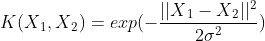
The Radial Basis Function also has its own parameter **Gamma**, which controls the distance of influence of a single point.
Low values of Gamma results in points further apart being grouped together while for high values of Gamma, points need to be close together to be considered of the same group. Generally a lower Gamma value results in greater accuracy
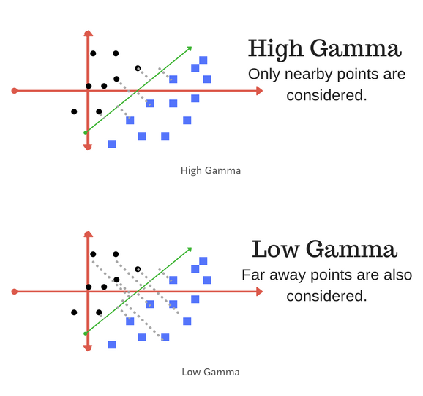

### C - Parameter
The Cost parameter in SVM, also known as a C-Parameter, is a hyperparameter which determines the soft-margin of the hyperplane. Real data are often noisy and not well defined at their boundary. Attempting to fit a hyperplane at such a boundary would result in either an overfit model or in certain cases, the hyperplane cannot be defined. A soft-margin containing purposefully misclassified points on either side of a hyperplane would allow for a better or more linear fit. The C-parameter adds a penalty for each misclassified data point. A smaller C results in a larger margin, while a larger C would mean a smaller margin with less misclassified data.
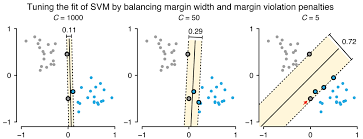


## Training SVM Models
We first do a general assessment of the various kernels at both extremities of the C parameter. We leave the Kernel specific hyperparameters as default as it the kernel type and C-Parameters that has the most significant impact on accuracy. Doing this will help us determine which kernel types and what range of C-Parameter we should conduct our gridsearch in, which would significantly reduce the computational cost of our hyperparameter tuning. We also conduct this assessment on our validation set which contains lesser samples to further reduce computational cost.

In [20]:
svc = SVC(kernel='linear',C=100, cache_size=1999)
svc.fit(Zval, Zvaltest)

pred = svc.predict(Ytrain)

print('Model accuracy score with kernel=linear c=100 hyperparameters: {0:0.4f}'.
      format(accuracy_score(Ytest, pred)))

Model accuracy score with kernel=linear c=100 hyperparameters: 0.7283


In [21]:
svc = SVC(kernel='linear', C=0.1, cache_size=1999)
svc.fit(Zval, Zvaltest)

pred = svc.predict(Ytrain)

print('Model accuracy score with kernel=linear c=0.1 hyperparameters: {0:0.4f}'.
      format(accuracy_score(Ytest, pred)))

Model accuracy score with kernel=linear c=0.1 hyperparameters: 0.7281


In [22]:
svc = SVC(kernel='rbf',C=100, cache_size=1999)
svc.fit(Zval, Zvaltest)

pred = svc.predict(Ytrain)

print('Model accuracy score with kernel=rbf c=100 hyperparameters: {0:0.4f}'.
      format(accuracy_score(Ytest, pred)))

Model accuracy score with kernel=rbf c=100 hyperparameters: 0.7178


In [23]:
svc = SVC(kernel='rbf',C=0.1, cache_size=1999)
svc.fit(Zval, Zvaltest)

pred = svc.predict(Ytrain)

print('Model accuracy score with kernel=rbf c=0.1 hyperparameters: {0:0.4f}'.
      format(accuracy_score(Ytest, pred)))

Model accuracy score with kernel=rbf c=0.1 hyperparameters: 0.7305


In [24]:
svc = SVC(kernel='poly',C=100, cache_size=1999)
svc.fit(Zval, Zvaltest)

pred = svc.predict(Ytrain)

print('Model accuracy score with kernel=polynomial c=100 hyperparameters: {0:0.4f}'.
      format(accuracy_score(Ytest, pred)))

Model accuracy score with kernel=polynomial c=100 hyperparameters: 0.7275


In [25]:
svc = SVC(kernel='poly',C=0.1, cache_size=1999)
svc.fit(Zval, Zvaltest)

pred = svc.predict(Ytrain)

print('Model accuracy score with kernel=polynomial c=0.1 hyperparameters: {0:0.4f}'.
      format(accuracy_score(Ytest, pred)))

Model accuracy score with kernel=polynomial c=0.1 hyperparameters: 0.7312


In [26]:
svc = SVC(kernel='sigmoid',C=100, cache_size=1999)
svc.fit(Zval, Zvaltest)

pred = svc.predict(Ytrain)

print('Model accuracy score with kernel=sigmoid c=100 hyperparameters: {0:0.4f}'.
      format(accuracy_score(Ytest, pred)))

Model accuracy score with kernel=sigmoid c=100 hyperparameters: 0.6298


In [21]:
svc = SVC(kernel='sigmoid',C=0.1, cache_size=1999)
svc.fit(Zval, Zvaltest)

pred = svc.predict(Ytrain)

print('Model accuracy score with kernel=sigmoid c=0.1 hyperparameters: {0:0.4f}'.
      format(accuracy_score(Ytest, pred)))

Model accuracy score with kernel=sigmoid c=0.1 hyperparameters: 0.6350


From these results, we determine that the RBF and Polynomial Kernel at a lower value C, provides the best accuracy.

## Improve accuracy by Hyperparameter tuning
### Optimal Hyperparameter via gridsearch
We will now determine a more optimal set of Hyperparameters for accuracy, using grid search. Grid search is a brute force method for hyperparameter tuning in the ScikitLearn library. It conducts a exaustive search for every specified hyperparameter value to determine the most optimal parameters. Grid search also utilizes cross-validation, which further divides the dataset to multiple smaller train an test sets, to net a better representation of the accuracy of specific parameter combinations.
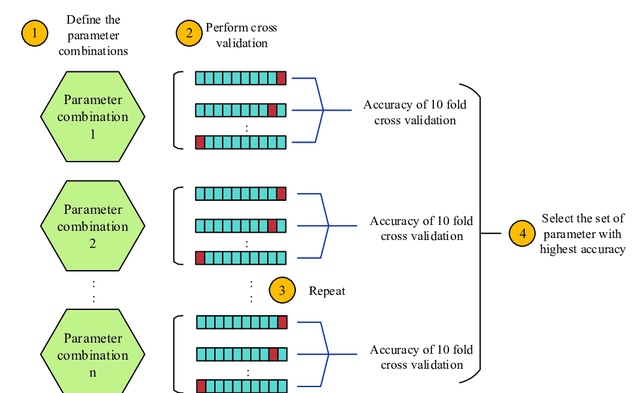

We initiate a grid search on the RBF and Poly Kernels, with a C-parameter range of [0.1, 0.5, 1, 5, 10], as we've determined that a lower C value nets a higher accuracy from our general assessment. We also choose the degree parameter for the Poly kernel as [2,4,6,8]. The Gamma parameter for the RBF kernel is kept at default as the default calculation of Gamma for sklearn's SVM is: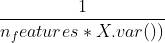
Which for our Zval validation set results in a Gamma value of 0.000146, an extremely low value. Hence we have decided not to tune our Gamma value as varying at such a low range would have little impact on our accuracy yet result in a much higher computational cost.

In [28]:
# instantiate classifier with default hyperparameters with kernel=rbf, C=1.0 and gamma=auto
svc = SVC()
# declare parameters for hyperparameter tuning
parameters = [ {'C':[0.1, 0.5, 1, 5, 10], 'kernel':['rbf'], 'cache_size':[1000]},
               {'C':[0.1, 0.5, 1, 5, 10], 'kernel':['poly'], 'degree': [2,4,6,8], 'cache_size':[1000]} 
             ]

grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 4,
                           verbose=3,
                           n_jobs=-3)

grid_search.fit(Zval, Zvaltest)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


GridSearchCV(cv=4, estimator=SVC(), n_jobs=-3,
             param_grid=[{'C': [0.1, 0.5, 1, 5, 10], 'cache_size': [1000],
                          'kernel': ['rbf']},
                         {'C': [0.1, 0.5, 1, 5, 10], 'cache_size': [1000],
                          'degree': [2, 4, 6, 8], 'kernel': ['poly']}],
             scoring='accuracy', verbose=3)

In [29]:
# examine the best model on validation set


# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))


# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))


# print estimator that was chosen by the GridSearch
print('\n\nEstimator that was chosen by the search :','\n\n', (grid_search.best_estimator_))

GridSearch CV best score : 0.7342


Parameters that give the best results : 

 {'C': 5, 'cache_size': 1000, 'kernel': 'rbf'}


Estimator that was chosen by the search : 

 SVC(C=5, cache_size=1000)


We have established out optimal parameter from our first grid search. Now we narrow down our specified parameter values to determine a more accurate set of optimal hyperparameters and we conduct the search on our main training set.

In [33]:
# instantiate classifier with default hyperparameters with kernel=rbf, C=1.0 and gamma=auto
svc = SVC()

# declare parameters for hyperparameter tuning
parameters = [ {'C':[0.5, 1, 2, 3, 4, 5, 6, 7], 'kernel':['rbf'], 'cache_size':[1000]}]

grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           verbose=3,
                           n_jobs=-3)

grid_search.fit(Ztrain, Ztest)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-3,
             param_grid=[{'C': [0.5, 1, 2, 3, 4, 5, 6, 7], 'cache_size': [1000],
                          'kernel': ['rbf']}],
             scoring='accuracy', verbose=3)

In [31]:


# best score achieved during the GridSearchCV
print('GridSearch CV best score : {:.4f}\n\n'.format(grid_search.best_score_))


# print parameters that give the best results
print('Parameters that give the best results :','\n\n', (grid_search.best_params_))

GridSearch CV best score : 0.7326


Parameters that give the best results : 

 {'C': 1, 'cache_size': 1000, 'kernel': 'rbf'}


We have found our most optimal set of hyperparameters and now we will fit it to our training set and and predict our test set.

In [35]:
svc = SVC(kernel='rbf',C=1, cache_size=1999)
svc.fit(Ztrain, Ztest)

bestpred = svc.predict(Ytrain)

print('Model accuracy score with kernel=rbf c=0.1 hyperparameters: {0:0.4f}'.
      format(accuracy_score(Ytest, bestpred)))

Model accuracy score with kernel=rbf c=0.1 hyperparameters: 0.7330


We achieved an accuracy of 73.3%, but it is not a good enough indicator of our model performance, as default accuracy can be misleading due to accuracy paradox and imbalanced class distribution. To gain a better insight on model performace, we look into other forms of accuracy determination.

## Accuracy and Performance analysis


### Confusion Matrix
A Confusion Matrix generates a list of expected values and a list of predictions from our machine learning model and returns the result as an array. Each column represents the instances in an actual class, while each role represents the instances in our predicted class.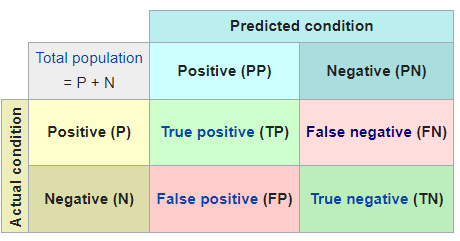

Calculating a confusion matrix can help us understand what our model gets right what what errors it makes. The values from a confusion matrix is also used to calculate different types of accuracies.

<AxesSubplot:>

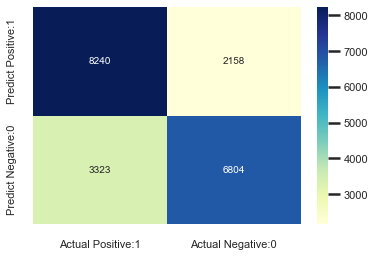

In [39]:
cm = confusion_matrix(Ytest, bestpred)
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sb.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [48]:
print('\nTrue Positives(TP) = ', cm[0,0])

print('\nTrue Negatives(TN) = ', cm[1,1])

print('\nFalse Positives(FP) Type 1 Error(Actual Negative, Predicted Positive) = ', cm[0,1])

print('\nFalse Negatives(FN) Type 2 Error(Actual Positive, Predicted Negative) = ', cm[1,0])


True Positives(TP) =  8240

True Negatives(TN) =  6804

False Positives(FP) Type 1 Error(Actual Negative, Predicted Positive) =  2158

False Negatives(FN) Type 2 Error(Actual Positive, Predicted Negative) =  3323


From this we could tell that our classification model has a **higher tendency to misclassify positive cases of CVDs as negatives.**

**Precision** - Precision is a type of accuracy that attempts to display the proportions of positive identifications that are actually correct. Precision is useful in imbalanced classification problems where the majority class is negative. Precision is defined as: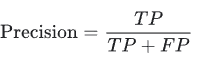

**Recall** - Recall attempts to display the proportions of actual positives that was identified correctly. A model with no false negatives will have a Recall of 0. Recall is defined as: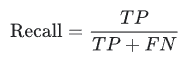

**F1-Score** - F1-Score combines the Precision and Recall of a classification model into a single metric by taking their harmonic means. F1-Score is primarily used to compare between 2 classifiers. F1-Score is defined as follows: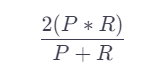
Where: P = Precison and R = Recall

In [45]:
print(classification_report(Ytest, bestpred, digits=4))

              precision    recall  f1-score   support

           0     0.7126    0.7925    0.7504     10398
           1     0.7592    0.6719    0.7129     10127

    accuracy                         0.7330     20525
   macro avg     0.7359    0.7322    0.7316     20525
weighted avg     0.7356    0.7330    0.7319     20525



### ROC AUC
The Receiver Operating Characteristic(ROC) curve graphs the performance of a classification model at all classification thresholds

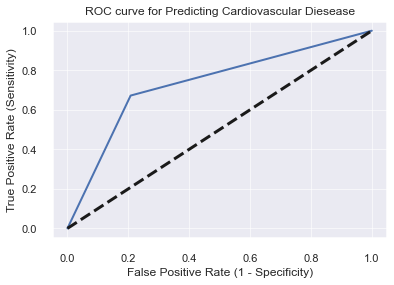

In [46]:
# plot ROC Curve

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(Ytest, bestpred)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Predicting Cardiovascular Diesease')

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

In [47]:
#compute ROC AUC

from sklearn.metrics import roc_auc_score

ROC_AUC = roc_auc_score(Ytest, bestpred)

print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.7322
